**Plotting Seahorse Results**

In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')

from ABCA7lof2.seahorse import ImageBrowser, compute_seahorse_measures_per_well_long_run, compute_seahorse_measures_per_well_short_run, plot_boxplot_by_treatment

In [2]:
import os
import urllib.request
### Save batch 1 data
filenames = [
    "batch1_df_quant.csv", 
    "batch1.csv", 
    "iN_ABCA7KO_50k_25k_03132024.xlsx"
]

output_dir = "../../seahorse/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in filenames:
    # Skip if file already exists
    local_filename = os.path.join(output_dir, filename)
    if os.path.exists(local_filename):
        print(f"Skipping {filename} - already downloaded")
        continue
    url = f'https://storage.googleapis.com/abca7lof/seahorse/{filename}'
    local_filename = os.path.join(output_dir, filename)
    urllib.request.urlretrieve(url, local_filename)
    print(f"Downloaded {filename} to {local_filename}")

Skipping batch1_df_quant.csv - already downloaded
Skipping batch1.csv - already downloaded
Skipping iN_ABCA7KO_50k_25k_03132024.xlsx - already downloaded


## LoF Effects

#### Batch 1

In [2]:
# load data
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03132024.xlsx'
x = ImageBrowser(file_path, long=False)

Output()

In [5]:
x.df

,Measurement,Well,Group,Time,OCR,ECAR,PER,randID
0,1,A01,Background,1.302014,0.0,0.0,0,94
1,1,A02,Background,1.302014,0.0,0.0,0,73
2,1,A03,Background,1.302014,0.0,0.0,0,57
3,1,A04,Background,1.302014,0.0,0.0,0,42
4,1,A05,Background,1.302014,0.0,0.0,0,2
...,...,...,...,...,...,...,...,...
1147,12,H08,Background,72.914893,0.0,0.0,0,74
1148,12,H09,Background,72.914893,0.0,0.0,0,40
1149,12,H10,Background,72.914893,0.0,0.0,0,32
1150,12,H11,Background,72.914893,0.0,0.0,0,54


In [12]:
# save filtering results
temp = pd.DataFrame(x.discard)
temp['keep'] = 0

temp2 = pd.DataFrame(x.keep_ids)
temp2['keep'] = 1

temp3 = pd.concat((temp,temp2))
temp3['batch'] = file_path

temp3.to_csv('../processed_data/seahorse_filtered/batch1.csv')

In [364]:
# load the filtered data
temp = pd.read_csv('../processed_data/seahorse_filtered/batch1.csv')
keep_ids = temp['0'][temp['keep']==1]
discard = temp['0'][temp['keep']==0]

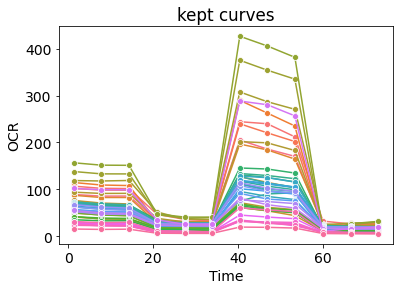

In [365]:
# plot keep ids
temp = x.df
sns.lineplot(data=temp[[i in set(keep_ids) for i in temp['Well']]], x = 'Time', y='OCR', hue = 'Well', marker = 'o')
plt.legend().set_visible(False)
plt.title('kept curves')

plt.savefig('../pdf_figures/batch_1_curves_25K.pdf')


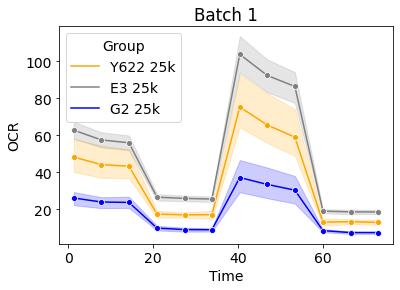

In [169]:
# plot traces
temp = x.df
sns.lineplot(data=temp[np.array([x in set(['Y622 25k', 'G2 25k', 'E3 25k']) for x in temp['Group']]) & np.array([i in set(keep_ids) for i in temp['Well']])], x = 'Time', y='OCR', hue = 'Group', marker = 'o', palette=['orange', 'grey',  'blue'])
plt.title('Batch 1')

plt.savefig('../pdf_figures/batch_1_traces_25K.pdf')


Text(0.5, 1.0, 'kept curves')

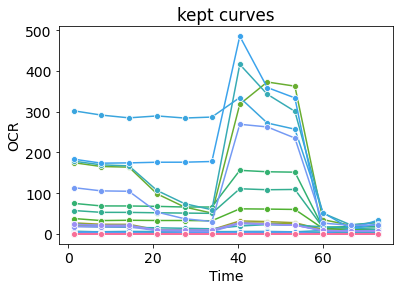

In [170]:
# plot discard ids
temp = x.df
sns.lineplot(data=temp[[i in set(discard) for i in temp['Well']]], x = 'Time', y='OCR', hue = 'Well', marker = 'o')
plt.legend().set_visible(False)
plt.title('discard curves')

In [31]:
# compute results
df = temp[[i in set(x.keep_ids) for i in temp['Well']]]

dictionary = dict(zip(df['Well'], df['Group']))

out = []

for well in np.unique(df['Well']):
    
    CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp = compute_seahorse_measures_per_well_short_run(well, df)
    condition = dictionary[well]
    out.append([condition, CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp])
    
df_quant = pd.DataFrame(out)
df_quant.columns = ['condition', 'CE', 'SRC', 'ATP_of_MAX', 'basal', 'proton_leak', 'atp_linked', 'max_resp']
df_quant['1-CE'] = 1-df_quant['CE']

df_quant.to_csv('../processed_data/seahorse_filtered/batch1_df_quant.csv')

In [366]:
# which conditions do we have after filtering?
df_quant = pd.read_csv('../processed_data/seahorse_filtered/batch1_df_quant.csv')
pd.DataFrame(np.unique(df_quant['condition'], return_counts=True))

,0,1,2,3,4,5
0,E3 25k,E3 50k,G2 25k,G2 50k,Y622 25k,Y622 50k
1,10,8,7,1,7,9


In [367]:
# compute the means
T = (df_quant.groupby('condition')['1-CE'].mean().reset_index())
dictionary = dict(zip(T['condition'], T['1-CE']))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:2.225e-05 t=6.050e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:9.959e-07 t=7.906e+00


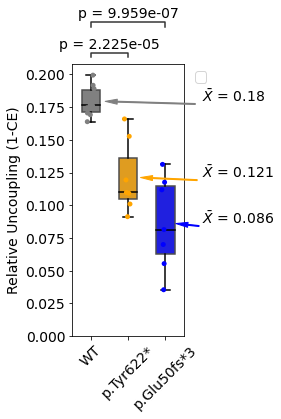

In [138]:
# plot the results
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')),(('E3 25k'), ('G2 25k'))]
palette=['grey', 'orange', 'blue']

plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(df_quant, 'condition', '1-CE', order, pairs, palette) 
plt.ylim(bottom=0)

for i, name in enumerate(order):
    plt.annotate(r'$\bar{X}$ = '+str(np.round(dictionary[name],3)),
                    xy=(i+.25, dictionary[name]),
                    xytext=(0 + 3, dictionary[name]),
                    arrowprops=dict(facecolor=palette[i], edgecolor=palette[i], shrink=0.05, headwidth=5, width=1))

plt.rcParams.update({'font.size': 14})
plt.xticks(ticks=[0, 1, 2], labels=['WT', 'p.Tyr622*','p.Glu50fs*3'], rotation=45)
plt.ylabel('Relative Uncoupling (1-CE)')
plt.savefig('../pdf_figures/batch_1_CE_25K.pdf')


/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/stats/StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
No arti

E3 50k vs. Y622 50k: t-test independent samples, P_val:1.243e-02 t=2.839e+00
E3 50k vs. G2 50k: t-test independent samples, P_val:nan t=nan


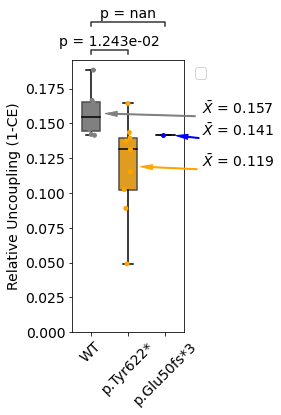

In [139]:
# plot the results
order = ['E3 50k', 'Y622 50k', 'G2 50k']
pairs = [(('E3 50k'), ('Y622 50k')),(('E3 50k'), ('G2 50k'))]
palette=['grey', 'orange', 'blue']

plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(df_quant, 'condition', '1-CE', order, pairs, palette) 
plt.ylim(bottom=0)

for i, name in enumerate(order):
    plt.annotate(r'$\bar{X}$ = '+str(np.round(dictionary[name],3)),
                    xy=(i+.25, dictionary[name]),
                    xytext=(0 + 3, dictionary[name]),
                    arrowprops=dict(facecolor=palette[i], edgecolor=palette[i], shrink=0.05, headwidth=5, width=1))

plt.rcParams.update({'font.size': 14})
plt.xticks(ticks=[0, 1, 2], labels=['WT', 'p.Tyr622*','p.Glu50fs*3'], rotation=45)
plt.ylabel('Relative Uncoupling (1-CE)')
plt.savefig('../pdf_figures/batch_1_CE_50k.pdf')


In [141]:
# compute the means
T = (df_quant.groupby('condition')['SRC'].mean().reset_index())
dictionary = dict(zip(T['condition'], T['SRC']))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:4.665e-02 t=-2.168e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:5.164e-03 t=-3.270e+00


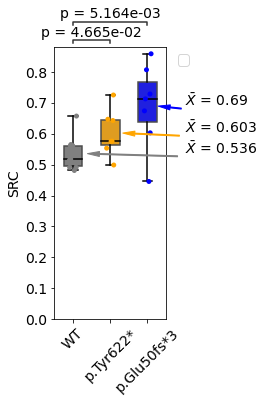

In [142]:
# plot the results
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')),(('E3 25k'), ('G2 25k'))]
palette=['grey', 'orange', 'blue']

plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(df_quant, 'condition', 'SRC', order, pairs, palette) 
plt.ylim(bottom=0)

for i, name in enumerate(order):
    plt.annotate(r'$\bar{X}$ = '+str(np.round(dictionary[name],3)),
                    xy=(i+.25, dictionary[name]),
                    xytext=(0 + 3, dictionary[name]),
                    arrowprops=dict(facecolor=palette[i], edgecolor=palette[i], shrink=0.05, headwidth=5, width=1))

plt.rcParams.update({'font.size': 14})
plt.xticks(ticks=[0, 1, 2], labels=['WT', 'p.Tyr622*','p.Glu50fs*3'], rotation=45)
plt.ylabel('SRC')
plt.savefig('../pdf_figures/batch_1_SRC_25K.pdf')


#### Batch 2

In [111]:
# load data
file_path = '../raw_data/seahorse/iN_ABCA7KO_03202024.xlsx'
x = ImageBrowser(file_path, long=False)

Output()

In [112]:
# had to toss most of this batch
x.keep_ids

['B03', 'B04', 'C04', 'B06']

#### Batch 3

In [11]:
# load data
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03272024_iNbatch02282024.xlsx'
x = ImageBrowser(file_path, long=False)

Output()

In [123]:
# save filtering results
temp = pd.DataFrame(x.discard)
temp['keep'] = 0

temp2 = pd.DataFrame(x.keep_ids)
temp2['keep'] = 1

temp3 = pd.concat((temp,temp2))
temp3['batch'] = file_path

temp3.to_csv('../processed_data/seahorse_filtered/batch3.csv')

In [12]:
# load the filtered data
temp = pd.read_csv('../processed_data/seahorse_filtered/batch3.csv')
keep_ids = temp['0'][temp['keep']==1]
discard = temp['0'][temp['keep']==0]

Text(0.5, 1.0, 'kept curves')

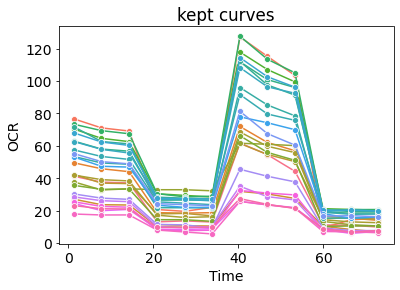

In [172]:
# plot keep ids
temp = x.df
sns.lineplot(data=temp[[i in set(keep_ids) for i in temp['Well']]], x = 'Time', y='OCR', hue = 'Well', marker = 'o')
plt.legend().set_visible(False)
plt.title('kept curves')

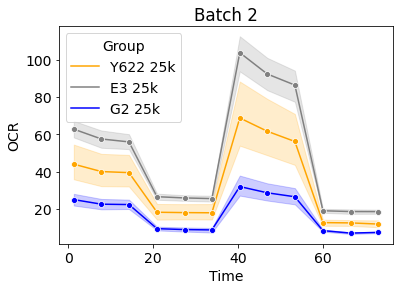

In [174]:
# plot traces
temp = x.df
sns.lineplot(data=temp[np.array([x in set(['Y622 25k', 'G2 25k', 'E3 25k']) for x in temp['Group']]) & np.array([i in set(keep_ids) for i in temp['Well']])], x = 'Time', y='OCR', hue = 'Group', marker = 'o', palette=['orange', 'grey',  'blue'])
plt.title('Batch 2')

plt.savefig('../pdf_figures/batch_2_traces_25K.pdf')


Text(0.5, 1.0, 'kept curves')

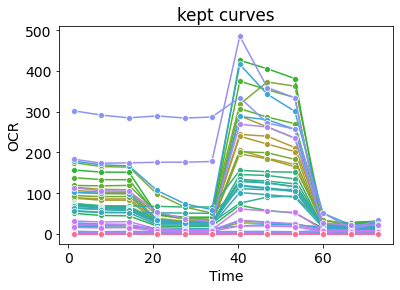

In [175]:
# plot discard ids
temp = x.df
sns.lineplot(data=temp[[i in set(discard) for i in temp['Well']]], x = 'Time', y='OCR', hue = 'Well', marker = 'o')
plt.legend().set_visible(False)
plt.title('kept curves')

In [126]:
# compute results
df = temp[[i in set(x.keep_ids) for i in temp['Well']]]

dictionary = dict(zip(df['Well'], df['Group']))

out = []

for well in np.unique(df['Well']):
    
    CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp = compute_seahorse_measures_per_well_short_run(well, df)
    condition = dictionary[well]
    out.append([condition, CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp])
    
df_quant = pd.DataFrame(out)
df_quant.columns = ['condition', 'CE', 'SRC', 'ATP_of_MAX', 'basal', 'proton_leak', 'atp_linked', 'max_resp']
df_quant['1-CE'] = 1-df_quant['CE']

df_quant.to_csv('../processed_data/seahorse_filtered/batch3_df_quant.csv')

In [127]:
# which conditions do we have after filtering?
pd.DataFrame(np.unique(df_quant['condition'], return_counts=True))

,0,1,2
0,E3 25k,G2 25k,Y622 25k
1,8,6,10


In [128]:
# compute the means
T = (df_quant.groupby('condition')['1-CE'].mean().reset_index())
dictionary = dict(zip(T['condition'], T['1-CE']))

In [129]:
T

,condition,1-CE
0,E3 25k,0.231707
1,G2 25k,0.166371
2,Y622 25k,0.174352


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:2.342e-02 t=2.505e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:3.004e-03 t=3.706e+00


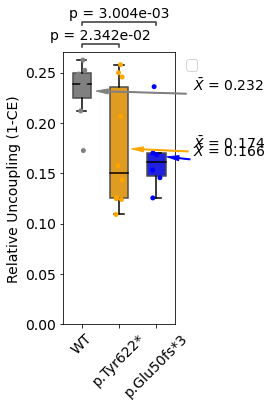

In [131]:
# plot the results
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')),(('E3 25k'), ('G2 25k'))]
palette=['grey', 'orange', 'blue']

plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(df_quant, 'condition', '1-CE', order, pairs, palette) 
plt.ylim(bottom=0)

for i, name in enumerate(order):
    plt.annotate(r'$\bar{X}$ = '+str(np.round(dictionary[name],3)),
                    xy=(i+.25, dictionary[name]),
                    xytext=(0 + 3, dictionary[name]),
                    arrowprops=dict(facecolor=palette[i], edgecolor=palette[i], shrink=0.05, headwidth=5, width=1))

plt.rcParams.update({'font.size': 14})
plt.xticks(ticks=[0, 1, 2], labels=['WT', 'p.Tyr622*','p.Glu50fs*3'], rotation=45)
plt.ylabel('Relative Uncoupling (1-CE)')
plt.savefig('../pdf_figures/batch_3_CE_25K.pdf')


In [132]:
# compute the means
T = (df_quant.groupby('condition')['SRC'].mean().reset_index())
dictionary = dict(zip(T['condition'], T['SRC']))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:3.759e-03 t=3.387e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:9.099e-01 t=-1.156e-01


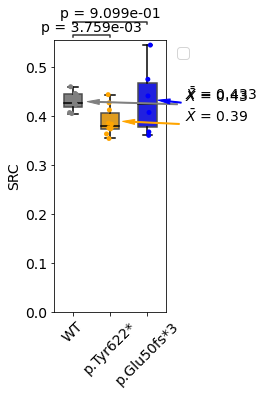

In [134]:
# plot the results
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')),(('E3 25k'), ('G2 25k'))]
palette=['grey', 'orange', 'blue']

plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(df_quant, 'condition', 'SRC', order, pairs, palette) 
plt.ylim(bottom=0)

for i, name in enumerate(order):
    plt.annotate(r'$\bar{X}$ = '+str(np.round(dictionary[name],3)),
                    xy=(i+.25, dictionary[name]),
                    xytext=(0 + 3, dictionary[name]),
                    arrowprops=dict(facecolor=palette[i], edgecolor=palette[i], shrink=0.05, headwidth=5, width=1))

plt.rcParams.update({'font.size': 14})
plt.xticks(ticks=[0, 1, 2], labels=['WT', 'p.Tyr622*','p.Glu50fs*3'], rotation=45)
plt.ylabel('SRC')
plt.savefig('../pdf_figures/batch_3_SRC_25K.pdf')


#### Batch 4

In [17]:
# load data
file_path = '../raw_data/seahorse/iN030620240_ABCA7KO_CDP-choline_04032024.xlsx'
x = ImageBrowser(file_path, long=False)

Output()

In [177]:
# save filtering results
temp = pd.DataFrame(x.discard)
temp['keep'] = 0

temp2 = pd.DataFrame(x.keep_ids)
temp2['keep'] = 1

temp3 = pd.concat((temp,temp2))
temp3['batch'] = file_path

temp3.to_csv('../processed_data/seahorse_filtered/batch4.csv')

In [18]:
# load the filtered data
temp = pd.read_csv('../processed_data/seahorse_filtered/batch4.csv')
keep_ids = temp['0'][temp['keep']==1]
discard = temp['0'][temp['keep']==0]

In [19]:
# also remove this well that has much lower OCR compared to the rest: G05

keep_ids = keep_ids[[x not in ['G05'] for x in keep_ids]]

Text(0.5, 1.0, 'kept curves')

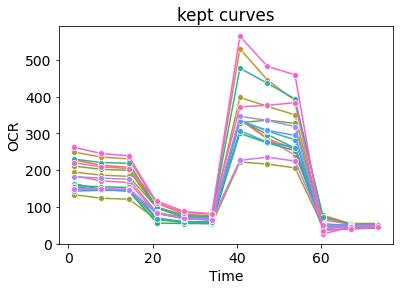

In [20]:
# plot keep ids
temp = x.df
sns.lineplot(data=temp[[i in set(keep_ids) for i in temp['Well']]], x = 'Time', y='OCR', hue = 'Well', marker = 'o')
plt.legend().set_visible(False)
plt.title('kept curves')
#plt.savefig('../pdf_figures/batch4_individual_curves.pdf')

In [6]:
np.unique(temp[[i in set(keep_ids) for i in temp['Well']]]['Group'])

array(['G2 CDP-choline', 'Y622 CDP-choline', 'Y622 H2O'], dtype=object)

Text(0.5, 1.0, 'Batch 4')

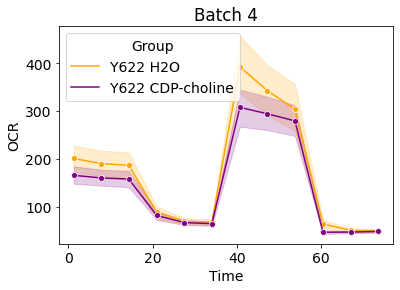

In [21]:
# plot traces
temp = x.df
sns.lineplot(data=temp[np.array([x in set(['Y622 CDP-choline', 'Y622 H2O']) for x in temp['Group']]) & np.array([i in set(keep_ids) for i in temp['Well']])], x = 'Time', y='OCR', hue = 'Group', marker = 'o', palette=['orange', 'purple'])
plt.title('Batch 4')

#plt.savefig('../pdf_figures/batch_4_traces.pdf')


Text(0.5, 1.0, 'discarded curves')

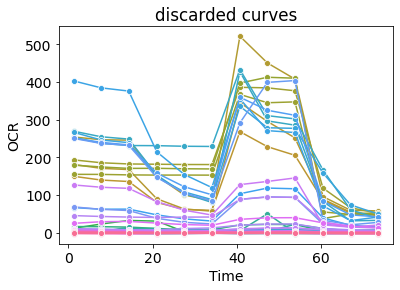

In [22]:
# plot discard ids
temp = x.df
sns.lineplot(data=temp[[i in set(discard) for i in temp['Well']]], x = 'Time', y='OCR', hue = 'Well', marker = 'o')
plt.legend().set_visible(False)
plt.title('discarded curves')

In [23]:
# compute results
df = temp[[i in set(keep_ids) for i in temp['Well']]]

dictionary = dict(zip(df['Well'], df['Group']))

out = []

for well in np.unique(df['Well']):
    
    CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp = compute_seahorse_measures_per_well_short_run(well, df)
    condition = dictionary[well]
    out.append([condition, CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp])
    
df_quant = pd.DataFrame(out)
df_quant.columns = ['condition', 'CE', 'SRC', 'ATP_of_MAX', 'basal', 'proton_leak', 'atp_linked', 'max_resp']
df_quant['1-CE'] = 1-df_quant['CE']

#df_quant.to_csv('../processed_data/seahorse_filtered/batch4_df_quant.csv')

In [24]:
# which conditions do we have after filtering?
pd.DataFrame(np.unique(df_quant['condition'], return_counts=True))

,0,1,2
0,G2 CDP-choline,Y622 CDP-choline,Y622 H2O
1,2,8,6


In [25]:
# compute the means
T = (df_quant.groupby('condition')['1-CE'].mean().reset_index())
dictionary = dict(zip(T['condition'], T['1-CE']))

In [9]:
T

,condition,1-CE
0,G2 CDP-choline,0.274236
1,Y622 CDP-choline,0.200271
2,Y622 H2O,0.144933


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Y622 H2O vs. Y622 CDP-choline: t-test independent samples, P_val:2.820e-03 t=-3.740e+00


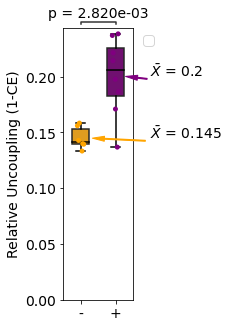

In [27]:
# plot the results
order = ['Y622 H2O', 'Y622 CDP-choline']
pairs = [(( 'Y622 H2O'), ('Y622 CDP-choline'))]
palette=['orange', 'purple']

plt.figure(figsize=(1.25,5))

plot_boxplot_by_treatment(df_quant, 'condition', '1-CE', order, pairs, palette) 
plt.ylim(bottom=0)

for i, name in enumerate(order):
    plt.annotate(r'$\bar{X}$ = '+str(np.round(dictionary[name],3)),
                    xy=(i+.25, dictionary[name]),
                    xytext=(0 + 2, dictionary[name]),
                    arrowprops=dict(facecolor=palette[i], edgecolor=palette[i], shrink=0.05, headwidth=5, width=1))

plt.rcParams.update({'font.size': 14})
plt.xticks(ticks=[0, 1], labels=['-', '+'], rotation=0)
plt.ylabel('Relative Uncoupling (1-CE)')
plt.savefig('../pdf_figures/cdp_choline_rescue_means.pdf')


In [13]:
def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette, ax1):
    
    sns.boxplot(ax=ax1, data = d, x = x_val, showfliers=False, y = y_val, palette = palette, dodge = True, order = order, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=d, x= x_val, y=y_val, dodge=True, jitter=True, alpha=1,  order = order, palette = palette, ax=ax1)


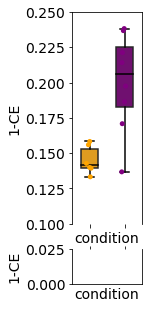

In [14]:

from statannotations.Annotator import Annotator

fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True, figsize=(1.25, 5), gridspec_kw={'height_ratios': [6, 1]})

plot_boxplot_by_treatment(df_quant, 'condition', '1-CE', order, pairs, palette,ax1) 
ax1.set_ylim(0, 0.025)  # Adjust the upper limit to show high values
ax2.spines['bottom'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put tick labels at the top
ax1.spines['top'].set_visible(False)


plot_boxplot_by_treatment(df_quant, 'condition', '1-CE', order, pairs, palette,ax2) 
ax2.set_ylim(0.1, 0.25)  # Adjust the lower limit to show low values
#ax2.spines['top'].set_visible(False)
ax2.xaxis.tick_bottom()

plt.savefig('../pdf_figures/cdp_choline_coupling_rescue_1.pdf')


In [210]:
# compute the means
T = (df_quant.groupby('condition')['SRC'].mean().reset_index())
dictionary = dict(zip(T['condition'], T['SRC']))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Y622 H2O vs. Y622 CDP-choline: t-test independent samples, P_val:6.808e-01 t=4.215e-01


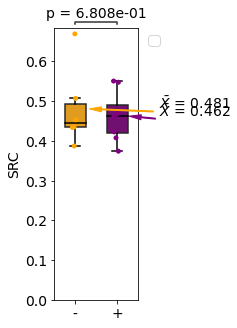

In [213]:
# plot the results
order = ['Y622 H2O', 'Y622 CDP-choline']
pairs = [(( 'Y622 H2O'), ('Y622 CDP-choline'))]
palette=['orange', 'purple']


plt.figure(figsize=(1.5,5))

plot_boxplot_by_treatment(df_quant, 'condition', 'SRC', order, pairs, palette) 
plt.ylim(bottom=0)

for i, name in enumerate(order):
    plt.annotate(r'$\bar{X}$ = '+str(np.round(dictionary[name],3)),
                    xy=(i+.25, dictionary[name]),
                    xytext=(0 + 2, dictionary[name]),
                    arrowprops=dict(facecolor=palette[i], edgecolor=palette[i], shrink=0.05, headwidth=5, width=1))

plt.rcParams.update({'font.size': 14})
plt.xticks(ticks=[0, 1], labels=['-', '+'], rotation=0)
plt.ylabel('SRC')
plt.savefig('../pdf_figures/batch_4_SRC_25K.pdf')


### Batches 5-9 not good quality

#### Batch 5

In [214]:
# load data
file_path = '../raw_data/seahorse/05012024_seahorse_data_3plates/iN_ABCA7KO_04032024_plate1.xlsx'
x = ImageBrowser(file_path, long=True)

Output()

In [215]:
# save filtering results
temp = pd.DataFrame(x.discard)
temp['keep'] = 0

temp2 = pd.DataFrame(x.keep_ids)
temp2['keep'] = 1

temp3 = pd.concat((temp,temp2))
temp3['batch'] = file_path

temp3.to_csv('../processed_data/seahorse_filtered/batch5.csv')

In [2]:
df = pd.read_csv('../processed_data/seahorse_filtered/batch5.csv')

In [7]:
df[df['keep']==1]

,Unnamed: 0,0,keep,batch


#### Batch 6

In [216]:
# load data
file_path = '../raw_data/seahorse/05012024_seahorse_data_3plates/iN_ABCA7KO_04032024_plate2.xlsx'
x = ImageBrowser(file_path, long=True)

Output()

In [217]:
# save filtering results
temp = pd.DataFrame(x.discard)
temp['keep'] = 0

temp2 = pd.DataFrame(x.keep_ids)
temp2['keep'] = 1

temp3 = pd.concat((temp,temp2))
temp3['batch'] = file_path

temp3.to_csv('../processed_data/seahorse_filtered/batch6.csv')

In [10]:
df = pd.read_csv('../processed_data/seahorse_filtered/batch6.csv')
df[df['keep']==1]

,Unnamed: 0,0,keep,batch


#### Batch 7

In [218]:
# load data
file_path = '../raw_data/seahorse/05012024_seahorse_data_3plates/iN_ABCA7KO_04032024_plate3.xlsx'
x = ImageBrowser(file_path, long=True)

Output()

In [219]:
# save filtering results
temp = pd.DataFrame(x.discard)
temp['keep'] = 0

temp2 = pd.DataFrame(x.keep_ids)
temp2['keep'] = 1

temp3 = pd.concat((temp,temp2))
temp3['batch'] = file_path

temp3.to_csv('../processed_data/seahorse_filtered/batch7.csv')

In [15]:
df = pd.read_csv('../processed_data/seahorse_filtered/batch7.csv')
df[df['keep']==1]

,Unnamed: 0,0,keep,batch


#### Batch 8

In [21]:
# load data
# was a bit more generous with these curves; accepting 1 dip after atp synth inhibition, because quality not good - but not using
file_path = '../raw_data/seahorse/05082024_seahorse_data_2plates/iN_ABCA7KO_04102024_plate1.xlsx'
x = ImageBrowser(file_path, long=True)

Output()

In [295]:
# save filtering results
temp = pd.DataFrame(x.discard)
temp['keep'] = 0

temp2 = pd.DataFrame(x.keep_ids)
temp2['keep'] = 1

temp3 = pd.concat((temp,temp2))
temp3['batch'] = file_path

temp3.to_csv('../processed_data/seahorse_filtered/batch8.csv')

In [34]:
df = pd.read_csv('../processed_data/seahorse_filtered/batch8.csv')
df = pd.merge(x.df, df, left_on = 'Well', right_on = '0')
df = df[df['keep']==1]

In [38]:
pd.DataFrame(np.unique(df.drop_duplicates('Well')['Group'], return_counts=True))

,0,1,2,3,4,5,6
0,E3 choline+eto,G2 choline+eto,G2 control+eto,G2 rosi+eto,Y622 choline+eto,Y622 control+eto,Y622 rosi+eto
1,1,5,6,4,4,4,3


#### Batch 9

In [279]:
# load data
# was a bit more generous with these curves; accepting 1 dip after atp synth inhibition, because quality not good - but not using
file_path = '../raw_data/seahorse/05082024_seahorse_data_2plates/iN_ABCA7KO_04102024_plate2.xlsx'
x = ImageBrowser(file_path, long=True)

Output()

In [280]:
# save filtering results
temp = pd.DataFrame(x.discard)
temp['keep'] = 0

temp2 = pd.DataFrame(x.keep_ids)
temp2['keep'] = 1

temp3 = pd.concat((temp,temp2))
temp3['batch'] = file_path

temp3.to_csv('../processed_data/seahorse_filtered/batch9.csv')

## combine across batches for main figure

In [39]:
df_quant = pd.read_csv('../processed_data/seahorse_filtered/batch1_df_quant.csv')
df_quant2 = pd.read_csv('../processed_data/seahorse_filtered/batch3_df_quant.csv')

In [40]:
all_data = pd.concat((df_quant2, df_quant))


In [10]:
pd.DataFrame(np.unique(all_data['condition'], return_counts=True))

,0,1,2,3,4,5
0,E3 25k,E3 50k,G2 25k,G2 50k,Y622 25k,Y622 50k
1,18,8,13,1,17,9


In [352]:
# compute the means
T = (all_data.groupby('condition')['1-CE'].mean().reset_index())
dictionary = dict(zip(T['condition'], T['1-CE']))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:2.308e-03 t=3.303e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:2.200e-05 t=5.051e+00


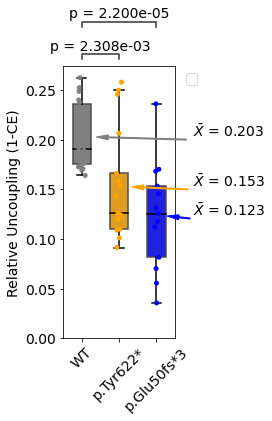

In [354]:
# plot the results
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')),(('E3 25k'), ('G2 25k'))]
palette=['grey', 'orange', 'blue']

plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(all_data, 'condition', '1-CE', order, pairs, palette) 
plt.ylim(bottom=0)

for i, name in enumerate(order):
    plt.annotate(r'$\bar{X}$ = '+str(np.round(dictionary[name],3)),
                    xy=(i+.25, dictionary[name]),
                    xytext=(0 + 3, dictionary[name]),
                    arrowprops=dict(facecolor=palette[i], edgecolor=palette[i], shrink=0.05, headwidth=5, width=1))

plt.rcParams.update({'font.size': 14})
plt.xticks(ticks=[0, 1, 2], labels=['WT', 'p.Tyr622*','p.Glu50fs*3'], rotation=45)
plt.ylabel('Relative Uncoupling (1-CE)')
plt.savefig('../pdf_figures/batch_1_3_CE_25K.pdf')


In [355]:
# compute the means
T = (all_data.groupby('condition')['SRC'].mean().reset_index())
dictionary = dict(zip(T['condition'], T['SRC']))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:7.247e-01 t=3.552e-01
E3 25k vs. G2 25k: t-test independent samples, P_val:7.235e-02 t=-1.865e+00


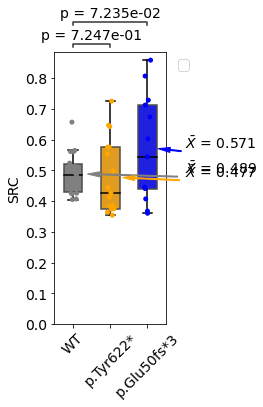

In [357]:
# plot the results
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')),(('E3 25k'), ('G2 25k'))]
palette=['grey', 'orange', 'blue']

plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(all_data, 'condition', 'SRC', order, pairs, palette) 
plt.ylim(bottom=0)

for i, name in enumerate(order):
    plt.annotate(r'$\bar{X}$ = '+str(np.round(dictionary[name],3)),
                    xy=(i+.25, dictionary[name]),
                    xytext=(0 + 3, dictionary[name]),
                    arrowprops=dict(facecolor=palette[i], edgecolor=palette[i], shrink=0.05, headwidth=5, width=1))

plt.rcParams.update({'font.size': 14})
plt.xticks(ticks=[0, 1, 2], labels=['WT', 'p.Tyr622*','p.Glu50fs*3'], rotation=45)
plt.ylabel('SRC')
plt.savefig('../pdf_figures/batch_1_3_SRC_25K.pdf')


### Supp table

In [66]:
# batch 1
temp = pd.read_csv('../processed_data/seahorse_filtered/batch1.csv')
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03132024.xlsx'
df_quant = pd.read_csv('../processed_data/seahorse_filtered/batch1_df_quant.csv')
x = ImageBrowser(file_path, long=False)
data = pd.merge(x.df, temp.iloc[:,1:], left_on = 'Well', right_on = '0')
data1 = data[[x in set(['Background', 'E3 25k',  'G2 25k',  'Y622 25k']) for x in data['Group']]]

Output()

In [67]:
# batch 3
temp = pd.read_csv('../processed_data/seahorse_filtered/batch3.csv')
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03272024_iNbatch02282024.xlsx'
df_quant = pd.read_csv('../processed_data/seahorse_filtered/batch3_df_quant.csv')
x = ImageBrowser(file_path, long=False)
data = pd.merge(x.df, temp.iloc[:,1:], left_on = 'Well', right_on = '0')
data3 = data[[x in set(['Background', 'E3 25k',  'G2 25k',  'Y622 25k']) for x in data['Group']]]

Output()

In [72]:
# batch 4
temp = pd.read_csv('../processed_data/seahorse_filtered/batch4.csv')
file_path = '../raw_data/seahorse/iN030620240_ABCA7KO_CDP-choline_04032024.xlsx'
df_quant = pd.read_csv('../processed_data/seahorse_filtered/batch4_df_quant.csv')
x = ImageBrowser(file_path, long=False)
data = pd.merge(x.df, temp.iloc[:,1:], left_on = 'Well', right_on = '0')
data4 = data[[x in set(['Background','Y622 H2O','Y622 CDP-choline']) for x in data['Group']]]

Output()

In [73]:
pd.concat((data1, data3, data4))

,Measurement,Well,Group,Time,OCR,ECAR,PER,randID,0,keep,batch
0,1,A01,Background,1.302014,0.0,0.0,0,55,A01,0,../raw_data/seahorse/iN_ABCA7KO_50k_25k_031320...
1,2,A01,Background,7.788320,0.0,0.0,0,55,A01,0,../raw_data/seahorse/iN_ABCA7KO_50k_25k_031320...
2,3,A01,Background,14.277262,0.0,0.0,0,55,A01,0,../raw_data/seahorse/iN_ABCA7KO_50k_25k_031320...
3,4,A01,Background,20.883667,0.0,0.0,0,55,A01,0,../raw_data/seahorse/iN_ABCA7KO_50k_25k_031320...
4,5,A01,Background,27.357721,0.0,0.0,0,55,A01,0,../raw_data/seahorse/iN_ABCA7KO_50k_25k_031320...
...,...,...,...,...,...,...,...,...,...,...,...
1147,8,H12,Background,47.240718,0.0,0.0,0,95,H12,0,../raw_data/seahorse/iN030620240_ABCA7KO_CDP-c...
1148,9,H12,Background,53.770463,0.0,0.0,0,95,H12,0,../raw_data/seahorse/iN030620240_ABCA7KO_CDP-c...
1149,10,H12,Background,60.411534,0.0,0.0,0,95,H12,0,../raw_data/seahorse/iN030620240_ABCA7KO_CDP-c...
1150,11,H12,Background,66.947896,0.0,0.0,0,95,H12,0,../raw_data/seahorse/iN030620240_ABCA7KO_CDP-c...


In [81]:
df_quant = pd.read_csv('../processed_data/seahorse_filtered/batch1_df_quant.csv')
df_quant['batch'] = 0
df_quant2 = pd.read_csv('../processed_data/seahorse_filtered/batch3_df_quant.csv')
df_quant2['batch'] = 1
df_quant3 = pd.read_csv('../processed_data/seahorse_filtered/batch4_df_quant.csv')
df_quant3['batch'] = 2

In [84]:
all_data = pd.concat((df_quant, df_quant2,df_quant3))
all_data = all_data[[x in set(['Background','Y622 H2O','Y622 CDP-choline', 'E3 25k', 'Y622 25k', 'G2 25k']) for x in all_data['condition']]]

In [85]:
all_data

,Unnamed: 0,condition,CE,SRC,ATP_of_MAX,basal,proton_leak,atp_linked,max_resp,1-CE,batch
5,5,Y622 25k,0.908686,0.642863,0.584160,357.954492,32.686382,325.268109,556.813049,0.091314,0
6,6,Y622 25k,0.880605,0.575947,0.507182,759.844652,90.721285,669.123367,1319.296005,0.119395,0
7,7,Y622 25k,0.899011,0.647036,0.581693,401.019763,40.498580,360.521184,619.779261,0.100989,0
12,12,Y622 25k,0.890153,0.575718,0.512477,298.364931,32.774578,265.590353,518.248231,0.109847,0
13,13,Y622 25k,0.834012,0.725459,0.605041,429.824417,71.345807,358.478610,592.486366,0.165988,0
...,...,...,...,...,...,...,...,...,...,...,...
9,9,Y622 H2O,0.860639,0.386886,0.332969,1320.777160,184.064591,1136.712569,3413.865769,0.139361,2
10,10,Y622 CDP-choline,0.785804,0.407366,0.320110,1222.735164,261.904466,960.830698,3001.564527,0.214196,2
11,11,Y622 CDP-choline,0.763188,0.373770,0.285257,1271.553452,301.119157,970.434295,3401.965419,0.236812,2
12,12,Y622 CDP-choline,0.802464,0.459465,0.368704,1730.681687,341.872706,1388.808981,3766.730609,0.197536,2
